## To run this colab, press the "Runtime" button in the menu tab and then press the "Run all" button.

##### Copyright 2019 The TensorFlow Authors.

# Recognize Driver Distraction using Transfer Learning

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

import os
import random
import keras

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.inception_resnet_v2 import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras.models import Sequential ,Model

from keras.engine import Layer
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape
from keras.layers import merge, concatenate, Activation, Dense, Dropout, Flatten , MaxPooling2D, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.core import RepeatVector, Permute

from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from keras.utils import Sequence
from keras.utils import data_utils
from keras.utils import to_categorical
from keras import initializers

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
!mkdir .kaggle
import json
token = {"username":"add your kaggle name","key":"add your kaggle key"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

- path is now set to: {/content}


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=8a78fbdd50280707bcd8d3206c1aefbc0d4149d7d39cc8d31039be960163e1da
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

In [ ]:
!unzip /content/{/content}/competitions/state-farm-distracted-driver-detection/state-farm-distracted-driver-detection.zip

In [ ]:
import pandas

df = pandas.read_csv('/content/driver_imgs_list.csv')
df.head()


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
from csv import reader
import os 

data_dir="/content/imgs/train"
data_array =[ ]
# skip first line i.e. read header first and then iterate over each row od csv as a list
with open('/content/driver_imgs_list.csv', 'r') as read_obj:
    csv_reader = reader(read_obj)
    header = next(csv_reader)
    # Check file as empty
    if header != None:
        # Iterate over each row after the header in the csv
        for row in csv_reader:
            # row variable is a list that represents a row in csv
            data_file = os.path.join(data_dir , str(row[1]) , str(row[2]) )
            sample ={
                'subject': row[0] ,
                'class': row[1] ,
                'img_path': data_file
            }
            data_array.append(sample)

## Setup Input Pipeline

In [ ]:
#define a data generator insted of loading all the images which is memory intensive
class DataGenerator(data_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_set , batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_set  = data_set
        self.on_epoch_end()
        self.image_shape=(224,224)
        self.transforms ={
            'mean':[0.485, 0.456, 0.406] ,
            'std' : [0.229, 0.224, 0.225]
        }

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_set) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch sample random indixes of batch size
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X=[]
        Y=[]
        #read images for each img file
        for idx in indexes :
            data_idx = self.data_set[idx]
            X.append(self.load_img(data_idx['img_path']))
            Y.append(int(data_idx['class'][1]))
        # Normalization => Converting pixel value from [0-255] to [0,1]  
        X = np.array(X)
        Y = np.array(Y)
        Y = to_categorical(Y, 10)
        return (X, Y)

    def on_epoch_end(self):
        'Updates indexes after each epoch ( random shuffle )'
        self.indexes = np.arange(len(self.data_set))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def load_img(self , file_name):
        
        img_rgb = load_img(file_name, grayscale=False, color_mode="rgb", 
                                              target_size=self.image_shape, interpolation="nearest")
        img = img_to_array(img_rgb)
        img = img /255.0
        img_normalized = ( img - self.transforms['mean'] ) / self.transforms['std']
        
        return img_normalized

In [ ]:
np.random.seed(1466)
train_val_split = 0.3
split_idx = int(train_val_split*len(data_array))
np.random.shuffle(data_array)

train_data = data_array[split_idx:]
val_data = data_array[:split_idx]

In [ ]:
train_generator = DataGenerator(train_data)
valid_generator = DataGenerator(val_data)

In [ ]:
x, y = next(iter(valid_generator))
print("Sample input batch : ", x.shape)
print("Sample target batch : ", y.shape)

Sample input batch :  (32, 224, 224, 3)
Sample target batch :  (32, 10)


In [ ]:
import matplotlib.pyplot as plt
mean= [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]
def viz_sample(samplex , sample_y):
    unnormalize_data = samplex*std + mean
    plt.title("Predicted Class : {}".format(str(sample_y)))
    plt.imshow(unnormalize_data)
    plt.show()

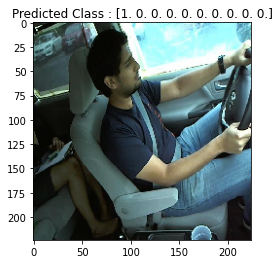

In [ ]:
viz_sample(x[1] , y[1])

## Create the base model from the pre-trained convnets

Create the base model from the **MobileNet V2** model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

First, pick which intermediate layer of MobileNet V2 will be used for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
IMAGE_SIZE= 224
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

### Try out with VGG16 model but results were reasonable but the model detction run time is not acceptable

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model_vgg16 = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

### Move to the MobileNetV1 model which is light weight model trained on ImagNet and having good perfomrace on embedded devices

In [ ]:
base_model_mobilenetv1 = tf.keras.applications.MobileNet(
    input_shape=IMAGE_SHAPE,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.3,
    include_top=False,
    weights="imagenet"
)

### MobileNetV2 experiment 

In [ ]:
base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    alpha=1.0,
    include_top=False,
    weights="imagenet"
)

### Experiments with Xception Model

In [ ]:
tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SHAPE
)

### Experiment with DenseNet Model

In [ ]:
base_model_densenet = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SHAPE
)

29089792/29084464 [==============================] - 0s 0us/step




```
Epoch 1/10
490/490 [==============================] - 403s 823ms/step - loss: 0.2337 - accuracy: 0.9320 - val_loss: 0.0360 - val_accuracy: 0.9894
Epoch 2/10
490/490 [==============================] - 402s 821ms/step - loss: 0.0200 - accuracy: 0.9953 - val_loss: 0.0247 - val_accuracy: 0.9927
Epoch 3/10
490/490 [==============================] - 401s 818ms/step - loss: 0.0174 - accuracy: 0.9953 - val_loss: 0.0682 - val_accuracy: 0.9811
Epoch 4/10
490/490 [==============================] - 401s 818ms/step - loss: 0.0272 - accuracy: 0.9929 - val_loss: 0.0380 - val_accuracy: 0.9888
Epoch 5/10
490/490 [==============================] - 401s 819ms/step - loss: 0.0101 - accuracy: 0.9972 - val_loss: 0.0293 - val_accuracy: 0.9936
Epoch 6/10
490/490 [==============================] - 400s 816ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0277 - val_accuracy: 0.9935
Epoch 7/10
490/490 [==============================] - 402s 820ms/step - loss: 0.0148 - accuracy: 0.9959 - val_loss: 0.0279 - val_accuracy: 0.9923
Epoch 8/10
490/490 [==============================] - 400s 817ms/step - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.0287 - val_accuracy: 0.9935
Epoch 9/10
490/490 [==============================] - 400s 816ms/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.0317 - val_accuracy: 0.9908
Epoch 10/10
490/490 [==============================] - 399s 815ms/step - loss: 0.0140 - accuracy: 0.9959 - val_loss: 0.0197 - val_accuracy: 0.9955
```



### Experiment with inceptionV3 model

In [ ]:
base_model_inception = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SHAPE
)

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model_inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [ ]:
base_model_inception.trainable = True

### Add a classification head

In [ ]:
model = tf.keras.Sequential([
  base_model_inception,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 3, 3, 32)          589856    
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 22,392,970
Trainable params: 22,358,538
Non-trainable params: 34,432
_________________________________________________________________


### Compile the model

You must compile the model before training it.  Since there are multiple classes, use a categorical cross-entropy loss.

In [ ]:
optimizer = keras.optimizers.Adam( learning_rate=0.0001, beta_1=0.9,
                                   beta_2=0.999,   epsilon=1e-07,name="Adam")
model.compile( optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          294944    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 3,524,138
Trainable params: 295,274
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 192


### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [ ]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=valid_generator, 
                    validation_steps=len(valid_generator), verbose=1)

Epoch 1/10
490/490 [==============================] - 200s 408ms/step - loss: 0.3448 - accuracy: 0.8938 - val_loss: 0.0520 - val_accuracy: 0.9868
Epoch 2/10
490/490 [==============================] - 200s 407ms/step - loss: 0.0436 - accuracy: 0.9896 - val_loss: 0.0533 - val_accuracy: 0.9829
Epoch 3/10
490/490 [==============================] - 200s 408ms/step - loss: 0.0410 - accuracy: 0.9901 - val_loss: 0.0311 - val_accuracy: 0.9933
Epoch 4/10
490/490 [==============================] - 196s 400ms/step - loss: 0.0322 - accuracy: 0.9908 - val_loss: 0.0373 - val_accuracy: 0.9917
Epoch 5/10
490/490 [==============================] - 189s 386ms/step - loss: 0.0148 - accuracy: 0.9964 - val_loss: 0.0465 - val_accuracy: 0.9918
Epoch 6/10
490/490 [==============================] - 187s 381ms/step - loss: 0.0174 - accuracy: 0.9956 - val_loss: 0.1741 - val_accuracy: 0.9601
Epoch 7/10
490/490 [==============================] - 184s 376ms/step - loss: 0.0268 - accuracy: 0.9922 - val_loss: 0.1165 -

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor. 

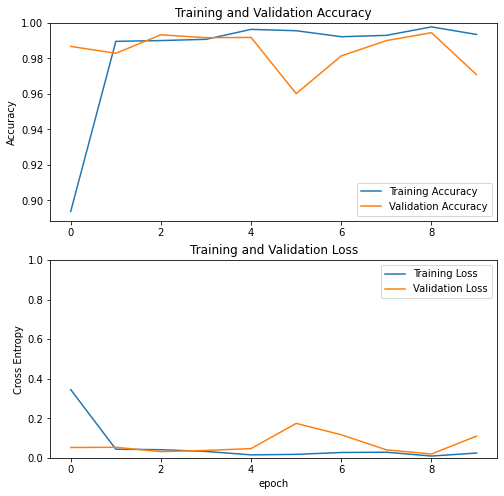

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 8

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Compile the model

Compile the model using a much lower training rate.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

### Continue Train the model

In [ ]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=5, 
                         validation_data=valid_generator, 
                         validation_steps=len(valid_generator))

## Convert to TFLite

Saved the model using `tf.saved_model.save` and then convert the saved model to a tf lite compatible format.

In [ ]:
saved_model_dir = 'save/fine_tuning_inception'
tf.saved_model.save(model, saved_model_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/fine_tuning_inception/assets


In [ ]:
def representative_data_gen():
  for input_value, _ in valid_generator:
    yield [input_value.astype(np.float32)]

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/save/fine_tuning_inception')
converter.optimizations =[tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()

In [ ]:
with open('model_inceptionv3.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
#tf lite model interpretation

interpreter = tf.lite.Interpreter(model_path='/content/model_inceptionv3.tflite')
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 355,
  'name': 'inception_v3_input',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
input_data = np.array([x[0]]).astype(np.float32)
input_data.shape

(1, 224, 224, 3)

In [ ]:
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tf_results = interpreter.get_tensor(output_details[0]['index'])

In [ ]:
def class_map(prediction):
    if(prediction==0):
        return 'safe driving'
    if(prediction==1):
        return 'texting - right'
    if(prediction==2):
        return 'talking on the phone - right'
    if(prediction==3):
        return 'texting - left'
    if(prediction==4):
        return 'talking on the phone - left'
    if(prediction==5):
        return 'operating the radio'
    if(prediction==6):
        return 'drinking'
    if(prediction==7):
        return 'reaching behind'
    if(prediction==8):
        return 'hair and makeup'
    if(prediction==9):
        return 'talking to passenger'

In [ ]:
def load_test(file_name):
        
    img_rgb = load_img(file_name, grayscale=False, color_mode="rgb", 
                                              target_size=(224,224), interpolation="nearest")
    img = img_to_array(img_rgb)
    img = img /255.0
    img_normalized = ( img - mean ) / std
    
    return img_normalized

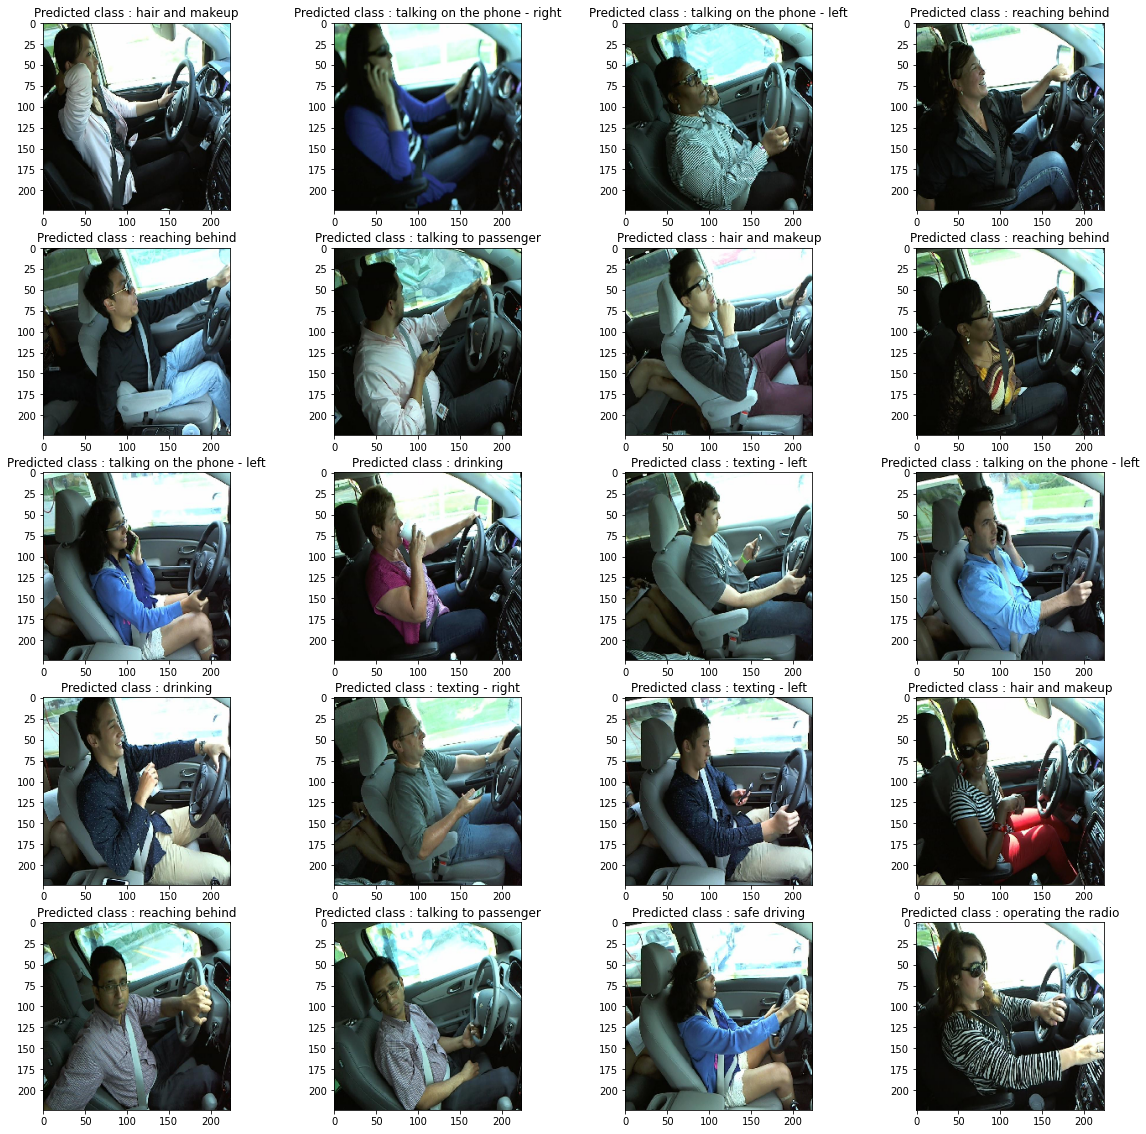

In [ ]:
import numpy as np
#load the test images for evaluation
data_dir = '/content/imgs/test'
test_img_list = os.listdir('/content/imgs/test')
#get some random samples from the dataset
plt.figure(figsize=(20,20)) # specifying the overall grid size
for i_check in range(20):
    #random choice of img path
    img_path = os.path.join(data_dir , np.random.choice(test_img_list))
    #load the image
    img_norm = load_test(img_path)
    single_batch = np.array([img_norm]).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_batch)
    interpreter.invoke()
    tf_results = interpreter.get_tensor(output_details[0]['index']) 
    max_class = np.argmax(tf_results)
    class_name = class_map(max_class)
    img_rgb = img_norm*std + mean
    plt.subplot(5,4,i_check+1)    # the number of images in the grid is 5*5 (25)
    plt.title("Predicted class : {}".format(str(class_name)))
    plt.imshow(img_rgb)
plt.show() 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp '/content/model_inceptionv3.tflite' -r '/content/drive/My Drive/MSC_models' 

In [ ]:
labels =['safe driving' , 'texting - right' , 'talking on the phone - right' ,'texting - left',
         'talking on the phone - left', 'operating the radio', 'drinking' ,'reaching behind' ,'hair and makeup' ,
         'talking to passenger' ]

labels = '\n'.join([ label for label in labels])

with open('labels.txt', 'w') as f:
  f.write(labels)

Download the converted model and labels

In [ ]:
from google.colab import files

files.download('labels.txt')
files.download('model.tflite')

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is common to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the orginial dataset that the pre-trained model was trained on.
